In [ ]:
%pip install numpy torch matplotlib

In [3]:
# ===============================
# Cell 1: Imports and Dependencies
# ===============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.colors import ListedColormap, BoundaryNorm
import random
import torch
import torch.nn as nn
from torch.distributions import Categorical
import collections
import heapq
from IPython.display import HTML
import os

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

plt.rcParams['animation.embed_limit'] = 100.0

In [4]:
# ===============================
# Cell 2: Complete UAV Environment with Global Maps
# ===============================

class UAVEnvironment:
    def __init__(self, grid_size=20, num_uavs=3, start_pos=(12,12), communication_range=8):
        self.grid_size = grid_size
        self.num_uavs = num_uavs
        self.start_pos = start_pos
        self.communication_range = communication_range
        
        # State
        self.uav_states, self.return_paths = {}, {}
        self.grid, self.uav_positions = np.zeros((grid_size, grid_size)), {}
        self.target_positions, self.found_targets = [], []
        self.paths = {}
        self.stuck_counters = {} 
        
        # NEW: Global Shared Maps (The "Fusion Map")
        self.global_explored_cells = set()
        self.global_discovered_obstacles = set()
        self.global_frontier = set()
        
        # This will be our "L fusion map" for visitation counts
        self.visitation_counts = np.zeros((grid_size, grid_size)) 
        
        self.start_positions = self._get_staggered_starts()
        
        # Simplified step counters
        self.last_new_cell_step, self.global_step_counter = {}, 0
        self.reset()

    def _a_star_search(self, start, goal, belief_map):
        def heuristic(a, b): return abs(a[0] - b[0]) + abs(a[1] - b[1])
        frontier = [(0, start)]
        came_from, cost_so_far = {start: None}, {start: 0}
        while frontier:
            _, current = heapq.heappop(frontier)
            if current == goal: break
            for dr, dc in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                ne = (current[0] + dr, current[1] + dc)
                if (0 <= ne[0] < self.grid_size 
                    and 0 <= ne[1] < self.grid_size 
                    and belief_map[ne] == 0):
                    new_cost = cost_so_far[current] + 1
                    if ne not in cost_so_far or new_cost < cost_so_far[ne]:
                        cost_so_far[ne] = new_cost
                        heapq.heappush(frontier, (new_cost + heuristic(goal, ne), ne))
                        came_from[ne] = current
        path, current = [], goal
        while current != start:
            if current not in came_from: return []
            path.append(current)
            current = came_from[current]
        path.reverse()
        return path

    def _get_staggered_starts(self):
        starts, base = {}, self.start_pos
        for i in range(self.num_uavs):
            offset_r, offset_c = i//2, i%2
            pos = (base[0] + offset_r, base[1] + offset_c)
            if pos[0]>=self.grid_size or pos[1]>=self.grid_size: pos = base
            starts[f'uav_{i}'] = pos
        return starts

    def _generate_uniform_obstacles(self):
        obstacle_density = np.random.uniform(0.12, 0.18)
        temp_grid = np.zeros((self.grid_size, self.grid_size))
        num_obstacles = int(self.grid_size**2 * obstacle_density)
        all_positions = [(i, j) for i in range(self.grid_size) for j in range(self.grid_size)]
        for pos in self.start_positions.values():
            if pos in all_positions:
                all_positions.remove(pos)
        for pos in random.sample(all_positions, min(num_obstacles, len(all_positions))):
            temp_grid[pos] = 1
        return temp_grid.astype(int)

    def _update_global_frontier(self):
        self.global_frontier = set()
        for cell in self.global_explored_cells:
            for dr, dc in [(0, 1), (0, -1), (1, 0), (-1,0)]:
                n = (cell[0]+dr, cell[1]+dc)
                if (0<=n[0]<self.grid_size and 
                    0<=n[1]<self.grid_size and
                    n not in self.global_explored_cells and
                    n not in self.global_discovered_obstacles and
                    self.grid[n]==0):
                    self.global_frontier.add(n)

    def _find_closest_frontier_distance(self, s, fs):
        return min([abs(s[0]-f[0])+abs(s[1]-f[1]) for f in fs]) if fs else float('inf')

    def _get_efficiency_bonus(self, agent):
        steps_since_discovery = self.global_step_counter - self.last_new_cell_step.get(agent, 0)
        return 1.0 if steps_since_discovery < 10 else 0.5 if steps_since_discovery < 30 else 0.0

    def _initiate_return_journey(self, agent, cur):
        self.uav_states[agent] = 'returning'
        
        # Use global maps for A*
        ce, co = self.global_explored_cells, self.global_discovered_obstacles
        bmap = np.ones_like(self.grid)
        for cell in ce: bmap[cell]=0
        for cell in co: bmap[cell]=1
        
        agent_start = self.start_positions[agent]
        path = self._a_star_search(cur, agent_start, bmap)
        self.return_paths[agent] = path if path else []

    def reset(self):
        self.grid = self._generate_uniform_obstacles()
        num_targets = np.random.randint(8, 15)
        self.target_positions, attempts = [], 0
        while len(self.target_positions)<num_targets and attempts<1000:
            x, y = np.random.randint(0, self.grid_size, 2)
            if self.grid[x, y]==0 and (x, y) not in self.start_positions.values(): 
                self.target_positions.append((x, y))
            attempts+=1
            
        self.uav_positions = self.start_positions.copy()
        self.found_targets = []
        self.paths = {f'uav_{i}': [self.start_positions[f'uav_{i}']] for i in range(self.num_uavs)}
        self.stuck_counters = {f'uav_{i}': 0 for i in range(self.num_uavs)}
        
        self.visitation_counts = np.zeros((self.grid_size, self.grid_size))
        for pos in self.start_positions.values():
            self.visitation_counts[pos]=1
            
        self.uav_states = {f'uav_{i}': 'exploring' for i in range(self.num_uavs)}
        self.return_paths = {f'uav_{i}': [] for i in range(self.num_uavs)}
        
        # Init global maps
        self.global_explored_cells = set(self.start_positions.values())
        self.global_discovered_obstacles = set()
        self.global_frontier = set()
        self._update_global_frontier()
        
        self.last_new_cell_step = {f'uav_{i}': 0 for i in range(self.num_uavs)}
        self.global_step_counter = 0
        return self.observe_all()

    def step(self, actions):
        rewards = {f'uav_{i}': 0 for i in range(self.num_uavs)}
        next_positions = {} 
        done = False
        self.global_step_counter += 1
        
        if all(state == 'returned' for state in self.uav_states.values()):
            return self.observe_all(), rewards, True
        
        newly_discovered_obstacles = set()

        for i in range(self.num_uavs):
            agent = f'uav_{i}'
            reward = 0
            current_pos = self.uav_positions[agent]
            current_state = self.uav_states[agent]
            
            if current_state == 'exploring':
                action = actions[agent]
                pos = list(current_pos)
                if action == 1 and pos[0] > 0: pos[0] -= 1
                elif action == 2 and pos[0] < self.grid_size-1: pos[0] += 1
                elif action == 3 and pos[1] > 0: pos[1] -= 1
                elif action == 4 and pos[1] < self.grid_size-1: pos[1] += 1
                new_pos = tuple(pos)
                
                # --- New Reward Logic ---
                
                # 1. Obstacle collision
                if self.grid[new_pos] == 1:
                    new_pos = current_pos
                    reward -= 2.0
                    newly_discovered_obstacles.add(new_pos)
                
                # 2. Frontier Navigation Reward
                if self.global_frontier:
                    db = self._find_closest_frontier_distance(current_pos, self.global_frontier)
                    da = self._find_closest_frontier_distance(new_pos, self.global_frontier)
                    reward += (db - da) * 2.0 # Positive if moving closer
                else:
                    reward -= 0.1 # No frontier, penalize lingering
                
                # 3. New Cell Discovery Reward
                if new_pos not in self.global_explored_cells:
                    self.global_explored_cells.add(new_pos)
                    self.last_new_cell_step[agent] = self.global_step_counter
                    reward += 5.0 # High reward for new global discovery
                    reward += self._get_efficiency_bonus(agent)
                    self.stuck_counters[agent] = 0
                else:
                    self.stuck_counters[agent] += 1
                    reward -= 0.05

                # 4. Visitation Penalty (from "L fusion map")
                reward -= self.visitation_counts[new_pos] * 0.1 
                
                # 5. Target Finding
                if new_pos in self.target_positions and new_pos not in self.found_targets: 
                    reward += 20.0
                    self.found_targets.append(new_pos)
                
                # 6. Check for nearby obstacles (local sensing)
                for dr, dc in [(0, 1), (0, -1), (1,0), (-1,0)]:
                    neighbor = (new_pos[0]+dr, new_pos[1]+dc)
                    if 0<=neighbor[0]<self.grid_size and 0<=neighbor[1]<self.grid_size and self.grid[neighbor]==1:
                        newly_discovered_obstacles.add(neighbor)

                # --- Simplified Stuck/Return Logic ---
                # Return if stuck for a long time
                if self.stuck_counters[agent] > 200:
                    self._initiate_return_journey(agent, new_pos)
            
            elif current_state == 'returning':
                if self.return_paths[agent]: 
                    new_pos = self.return_paths[agent].pop(0)
                else: 
                    new_pos = current_pos
                if new_pos == self.start_positions[agent]: 
                    self.uav_states[agent] = 'returned'
                    reward += 150
            
            else: # 'returned'
                new_pos = self.start_positions[agent]
            
            next_positions[agent] = new_pos
            rewards[agent] = reward
        
        # --- Post-step Updates ---
        
        # Update global obstacle map from all agents' sensing
        self.global_discovered_obstacles.update(newly_discovered_obstacles)
        
        pos_step = list(next_positions.values())
        for agent, pos in next_positions.items():
            if pos_step.count(pos) > 1: # Collision with teammate
                rewards[agent] -= 1.0
            
            # Update position and path
            self.uav_positions[agent] = pos
            self.paths[agent].append(pos)
            
            # Update L-Fusion map
            if self.uav_states[agent] == 'exploring':
                 self.visitation_counts[pos] += 1
        
        # Update the global frontier for the next observation
        self._update_global_frontier()
        
        if all(s in ['returning','returned'] for s in self.uav_states.values()): 
            done = True
        
        return self.observe_all(), rewards, done

    def observe_all(self):
        return {f'uav_{i}': self.observe(i) for i in range(self.num_uavs)}

    def observe(self, agent_idx):
        agent_id = f'uav_{agent_idx}'
        my_pos = self.uav_positions[agent_id]
        
        # 1. Global Obstacle View
        global_obstacle_view = np.zeros_like(self.grid)
        for obs_pos in self.global_discovered_obstacles: 
            global_obstacle_view[obs_pos] = 1

        # 2. Target View
        target_view = np.zeros_like(self.grid)
        for t in self.target_positions:
            if t not in self.found_targets: 
                target_view[t] = 1
        
        # 3. Teammate Position View
        teammate_pos_view = np.zeros_like(self.grid)
        for j in range(self.num_uavs):
            if j == agent_idx: continue
            teammate_pos_view[self.uav_positions[f'uav_{j}']] = 1
            
        # 4. My Position View
        my_pos_view = np.zeros_like(self.grid)
        my_pos_view[my_pos] = 1
        
        # 5. Global Explored View
        global_explored_view = np.zeros_like(self.grid)
        for cell in self.global_explored_cells:
            global_explored_view[cell] = 1
            
        # 6. Global Frontier View
        global_frontier_view = np.zeros_like(self.grid)
        for cell in self.global_frontier:
            global_frontier_view[cell] = 1

        # 7. Visitation View (The "L Fusion Map")
        visitation_view = self.visitation_counts.copy()
        max_val = visitation_view.max()
        if max_val > 0:
            visitation_view = visitation_view / max_val # Normalize 0-1
            
        # 8. State View
        state_view = np.zeros_like(self.grid)
        state_map = {'exploring': 0.5, 'returning': 1.0, 'returned': 1.0}
        state_view.fill(state_map.get(self.uav_states[agent_id], 0.5))
        
        # 9. Time/Step View
        time_view = np.full_like(self.grid, self.global_step_counter / 2200.0) # 2200 is max_steps
        
        return np.stack([
            global_obstacle_view,
            target_view,
            teammate_pos_view,
            my_pos_view,
            global_explored_view,
            global_frontier_view,
            visitation_view,
            state_view,
            time_view
        ], axis=0).flatten()
    
    def get_grid_visualization(self):
        grid_vis = self.grid.copy()
        for t_pos in self.target_positions:
            if t_pos not in self.found_targets: 
                grid_vis[t_pos] = 2
        for t_pos in self.found_targets: 
            grid_vis[t_pos] = 6
        for i in range(self.num_uavs):
            grid_vis[self.uav_positions[f'uav_{i}']] = 3 + i
        return grid_vis

In [5]:
# ===============================
# Cell 3: Neural Network Architectures for MAPPO
# ===============================

class ActorNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        logits = self.net(x)
        return Categorical(logits=logits)

class CriticNetwork(nn.Module):
    def __init__(self, obs_dim_total):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim_total, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

In [6]:
# ===============================
# Cell 4: MAPPO Agent Implementation
# ===============================

class MAPPO:
    def __init__(self, obs_dim, action_dim, n_agents, config):
        self.n_agents = n_agents
        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Shared actor for all agents
        self.actor = ActorNetwork(obs_dim, action_dim).to(self.device)
        
        # Centralized critic
        self.critic = CriticNetwork(obs_dim * n_agents).to(self.device)
        
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=config['lr'])
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=config['lr'])
        
        self.config = config
        self.reset_buffer()

    
    def save_checkpoint(self, path, episode, rewards):
        """Saves model weights, optimizer states, episode, and rewards."""
        checkpoint = {
            'episode': episode,
            'actor_state_dict': self.actor.state_dict(),
            'critic_state_dict': self.critic.state_dict(),
            'actor_optimizer_state_dict': self.actor_optimizer.state_dict(),
            'critic_optimizer_state_dict': self.critic_optimizer.state_dict(),
            'rewards': rewards
        }
        torch.save(checkpoint, path)

    def load_models(self, path):
        """Loads the actor and critic models."""
        checkpoint = torch.load(path, map_location=self.device)
        self.actor.load_state_dict(checkpoint['actor_state_dict'])
        self.critic.load_state_dict(checkpoint['critic_state_dict'])
        print(f"Loaded models from {path}")
     
    def reset_buffer(self):
        self.obs_buf = []
        self.action_buf = []
        self.logprob_buf = []
        self.reward_buf = []
        self.value_buf = []
        self.done_buf = []

    def select_action(self, obs_dict):
        actions = {}
        log_probs = {}
        
        for i in range(self.n_agents):
            obs = torch.FloatTensor(obs_dict[f'uav_{i}']).to(self.device).unsqueeze(0)
            dist = self.actor(obs)
            action = dist.sample()
            actions[f'uav_{i}'] = action.item()
            log_probs[f'uav_{i}'] = dist.log_prob(action).item()
        
        return actions, log_probs

    def get_value(self, global_obs):
        global_obs_tensor = torch.FloatTensor(global_obs).to(self.device).unsqueeze(0)
        return self.critic(global_obs_tensor).item()

    def store_transition(self, obs, actions, log_probs, rewards, value, done):
        self.obs_buf.append(obs)
        self.action_buf.append(actions)
        self.logprob_buf.append(log_probs)
        self.reward_buf.append(rewards)
        self.value_buf.append(value)
        self.done_buf.append(done)

    def learn(self):
        if len(self.obs_buf) == 0:
            return
            
        obs_t = torch.tensor(np.array(self.obs_buf), dtype=torch.float32).to(self.device)
        actions_t = torch.tensor(np.array(self.action_buf), dtype=torch.int64).to(self.device)
        logprobs_old_t = torch.tensor(np.array(self.logprob_buf), dtype=torch.float32).to(self.device)
        rewards_t = torch.tensor(np.array(self.reward_buf), dtype=torch.float32).to(self.device)
        values_t = torch.tensor(np.array(self.value_buf), dtype=torch.float32).to(self.device).squeeze(-1)
        dones_t = torch.tensor(np.array(self.done_buf), dtype=torch.float32).to(self.device)

        # Calculate advantages using GAE
        advantages = torch.zeros_like(rewards_t.mean(dim=-1))
        last_advantage = 0
        
        for t in reversed(range(len(rewards_t))):
            if t == len(rewards_t) - 1:
                next_done, next_value = 1.0, 0.0
            else:
                next_done, next_value = dones_t[t + 1], values_t[t + 1]
            
            mean_reward = rewards_t[t].mean()
            delta = mean_reward + self.config['gamma'] * next_value * (1.0 - next_done) - values_t[t]
            advantages[t] = delta + self.config['gamma'] * 0.95 * last_advantage * (1.0 - next_done)
            last_advantage = advantages[t]

        returns_t = advantages + values_t

        # Flatten for training
        b_obs = obs_t.reshape(-1, self.obs_dim)
        b_actions = actions_t.reshape(-1)
        b_logprobs_old = logprobs_old_t.reshape(-1)
        b_advantages = advantages.unsqueeze(1).repeat(1, self.n_agents).reshape(-1)

        # Actor loss
        dist = self.actor(b_obs)
        new_logprobs = dist.log_prob(b_actions)
        entropy_loss = dist.entropy().mean()

        ratio = torch.exp(new_logprobs - b_logprobs_old)
        surr1 = ratio * b_advantages
        surr2 = torch.clamp(ratio, 1 - self.config['clip'], 1 + self.config['clip']) * b_advantages
        actor_loss = -torch.min(surr1, surr2).mean()

        # Critic loss
        global_obs_t = obs_t.reshape(-1, self.obs_dim * self.n_agents)
        new_values = self.critic(global_obs_t).squeeze()
        critic_loss = nn.MSELoss()(new_values, returns_t)

        # Total loss
        loss = actor_loss - self.config['entropy_coef'] * entropy_loss + self.config['vf_coef'] * critic_loss

        # Update networks
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.actor.parameters(), 0.5)
        nn.utils.clip_grad_norm_(self.critic.parameters(), 0.5)
        self.actor_optimizer.step()
        self.critic_optimizer.step()

        self.reset_buffer()

In [7]:
# ===============================
# Cell 5: Visualization Function
# ===============================

def visualize_episode(env, agent, max_steps=1000, filename=None):
    """Optimized visualization to reduce memory usage and avoid PIL quantization errors."""
    fig, ax = plt.subplots(figsize=(6, 6))
    
    if filename:
        plt.close(fig) 
    
    # Initialize observation and state
    obs = env.reset()
    done = False
    step = 0
    
    # Initialize history lists
    grid_history = []
    paths_history = []
    states_history = []
    
    # Collect frames by running the episode
    while not done and step < max_steps:
        actions, _ = agent.select_action(obs)
        obs, rewards, done = env.step(actions)
        
        grid_history.append(env.get_grid_visualization())
        paths_history.append({k: list(v) for k, v in env.paths.items()})
        states_history.append(dict(env.uav_states))
        
        step += 1
    
    # Check if we have frames to animate
    if len(grid_history) == 0:
        print("No frames collected! Episode ended immediately.")
        plt.close(fig)
        return None
    
    print(f"Total frames collected: {len(grid_history)}")
    
    # Setup visualization
    cmap = ListedColormap(['#FFFFFF', '#34495e', '#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12'])
    bounds = [0, 1, 2, 3, 4, 5, 6, 7]
    norm = BoundaryNorm(bounds, cmap.N)
    path_colors = ['#3498db', '#2ecc71', '#9b59b6', '#e67e22']
    
    def animate(i):
        ax.clear()
        grid = grid_history[i]
        ax.imshow(grid, cmap=cmap, norm=norm)
        
        # === HOME REGION BOUNDARIES REMOVED ===
        
        # Draw paths
        curr_paths = paths_history[i]
        curr_states = states_history[i]
        for idx in range(env.num_uavs):
            agent_id = f'uav_{idx}'
            path = curr_paths[agent_id]
            if len(path) >= 2:
                rows, cols = zip(*path)
                ax.plot(cols, rows, color=path_colors[idx % len(path_colors)],
                        linewidth=2, alpha=0.7, label=f'UAV {idx} ({curr_states[agent_id]})')
        
        ax.set_title(f'Step {i+1}/{len(grid_history)}: UAV Exploration')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    anim = animation.FuncAnimation(fig, animate, frames=len(grid_history), interval=250)
    
    if filename:
        try:
            anim.save(filename, writer='pillow', fps=5)
            print(f"✓ Saved animation to {filename}")
        except Exception as e:
            print(f"Error saving animation: {e}")
        plt.close(fig)
        return None
    else:
        return HTML(anim.to_jshtml())

In [8]:
# ===============================
# Cell 6: Training Loop
# ===============================

def train_uav_mission():
    """Main training function with model checkpointing and file-based logging/visualization."""
    # --- Setup ---\
    run_name = "training_run_global_map_1" # New run name
    output_dir = os.path.join("results", run_name)
    model_dir = os.path.join(output_dir, "models")
    anim_dir = os.path.join(output_dir, "animations")
    log_file = os.path.join(output_dir, "training_log.txt")

    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(anim_dir, exist_ok=True)
    
    # Configuration
    config = {
        'lr': 2e-4, 
        'gamma': 0.99, 
        'clip': 0.2, 
        'vf_coef': 0.5, 
        'entropy_coef': 0.01
    }

    # Environment and Agent setup
    # Using the new refactored environment
    env = UAVEnvironment(grid_size=20, num_uavs=3, start_pos=(12, 12), communication_range=8)
    num_channels = 9
    obs_dim = (env.grid_size * env.grid_size) * num_channels
    agent = MAPPO(obs_dim=obs_dim, action_dim=5, n_agents=env.num_uavs, config=config)

    # Training parameters
    episodes = 2500 # Train for 2500 episodes
    max_steps_per_episode = 2200
    all_rewards = []

    print(f"Starting training run: {run_name}")
    print(f"Saving results to: {output_dir}")

    # --- Training Loop ---
    with open(log_file, "w") as f:
        f.write("Episode,Total_Reward\n")

    for ep in range(episodes):
        obs_dict = env.reset()
        ep_reward = 0

        for step in range(max_steps_per_episode):
            actions, log_probs = agent.select_action(obs_dict)
            obs_list = [obs_dict[f'uav_{i}'] for i in range(agent.n_agents)]
            global_obs = np.concatenate(obs_list)
            value = agent.get_value(global_obs)
            next_obs_dict, rewards_dict, done = env.step(actions)

            obs_arr = np.array(obs_list)
            action_arr = np.array([actions[f'uav_{i}'] for i in range(agent.n_agents)])
            log_prob_arr = np.array([log_probs[f'uav_{i}'] for i in range(agent.n_agents)])
            reward_arr = np.array([rewards_dict[f'uav_{i}'] for i in range(agent.n_agents)])
            agent.store_transition(obs_arr, action_arr, log_prob_arr, reward_arr, value, done)

            obs_dict = next_obs_dict
            ep_reward += reward_arr.sum()
            if done: break

        agent.learn()
        all_rewards.append(ep_reward)

        with open(log_file, "a") as f:
            f.write(f"{ep+1},{ep_reward}\n")

        # --- Checkpointing and Visualization ---
        if (ep + 1) % 50 == 0:
            avg_reward = np.mean(all_rewards[-50:])
            print(f"Episode {ep+1}/{episodes}, Avg Reward (last 50): {avg_reward:.2f}")

        if (ep + 1) % 200 == 0: # Checkpoint more often
            checkpoint_path = os.path.join(model_dir, f"model_ep_{ep+1}.pth")
            agent.save_checkpoint(checkpoint_path, ep+1, all_rewards)
            print(f"Checkpoint saved to {checkpoint_path}")
            

        if (ep + 1) % 500 == 0: # Animate less often
            anim_path = os.path.join(anim_dir, f"episode_{ep+1}.gif")
            print(f"  -> Generating visualization for episode {ep+1}...")
            # Need to create a temporary env for vis, as 'env' is mid-training
            vis_env = UAVEnvironment(grid_size=20, num_uavs=3, start_pos=(12, 12), communication_range=8)
            visualize_episode(vis_env, agent, max_steps=max_steps_per_episode, filename=anim_path)
            

    # At end of training
    final_path = os.path.join(model_dir, "final_model.pth")
    agent.save_checkpoint(final_path, episodes, all_rewards)
    print(f"Final model saved to {final_path}")

    # Plot training progress
    plt.figure(figsize=(12, 5))
    plt.plot(all_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward per Episode")
    plt.title("Training Progress")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "reward_curve.png"))
    plt.show()

    return env, agent

Starting training run: training_run_global_map_1
Saving results to: results\training_run_global_map_1
Episode 50/2500, Avg Reward (last 50): -1273.91
Episode 100/2500, Avg Reward (last 50): -1208.30
Episode 150/2500, Avg Reward (last 50): -916.52
Episode 200/2500, Avg Reward (last 50): -1099.00
Checkpoint saved to results\training_run_global_map_1\models\model_ep_200.pth
Episode 250/2500, Avg Reward (last 50): -1248.47
Episode 300/2500, Avg Reward (last 50): -1128.58
Episode 350/2500, Avg Reward (last 50): -1095.70
Episode 400/2500, Avg Reward (last 50): -904.61
Checkpoint saved to results\training_run_global_map_1\models\model_ep_400.pth
Episode 450/2500, Avg Reward (last 50): -1324.09
Episode 500/2500, Avg Reward (last 50): -1056.26
  -> Generating visualization for episode 500...
Total frames collected: 1718
✓ Saved animation to results\training_run_global_map_1\animations\episode_500.gif
Episode 550/2500, Avg Reward (last 50): -1039.97
Episode 600/2500, Avg Reward (last 50): -915.9

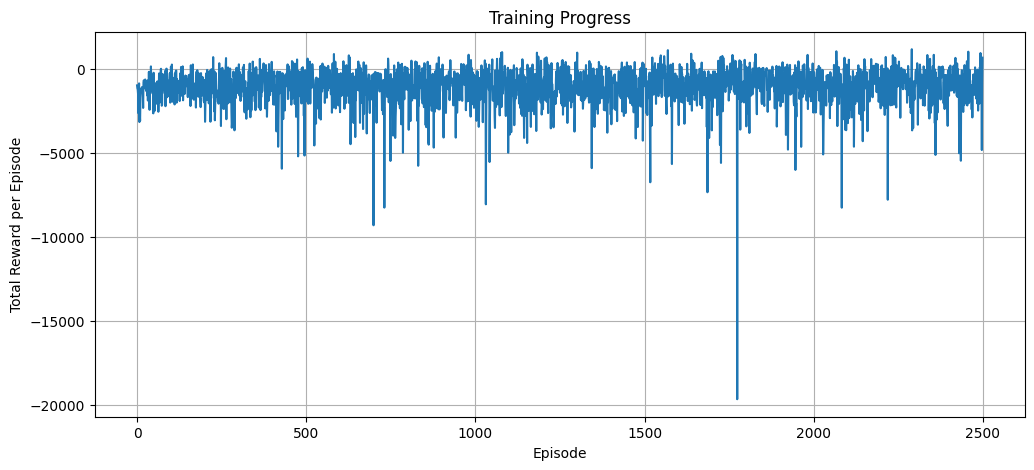

In [9]:
# ===============================
# Cell 7: Start New Training
# ===============================

# This will start a completely new training run using the refactored
# environment and save the results in 'results/training_run_global_map_1'

env, trained_agent = train_uav_mission()

In [10]:
# ===============================
# Cell 8: Load Trained Model for Evaluation
# ===============================

import glob
import os
import torch

# IMPORTANT: Update this to your new run directory
model_dir = "results/training_run_global_map_1/models"
run_name = "training_run_global_map_1"

# Find latest checkpoint if available
checkpoints = glob.glob(os.path.join(model_dir, "final_model.pth"))
if not checkpoints:
    raise FileNotFoundError(f"No 'final_model.pth' found in {model_dir}. Please run Cell 7 to train a model.")

latest_checkpoint = checkpoints[0]
print(f"Loading checkpoint for evaluation: {latest_checkpoint}")

# Setup environment and MAPPO agent (same config as training)
env = UAVEnvironment(grid_size=20, num_uavs=3, start_pos=(5, 5), communication_range=8)
num_channels = 9
obs_dim = (env.grid_size * env.grid_size) * num_channels
config = {
    'lr': 2e-4,
    'gamma': 0.99,
    'clip': 0.2,
    'vf_coef': 0.5,
    'entropy_coef': 0.01
}
trained_agent = MAPPO(obs_dim=obs_dim, action_dim=5, n_agents=env.num_uavs, config=config)

# Load checkpoint weights
checkpoint = torch.load(latest_checkpoint, weights_only=False)
trained_agent.actor.load_state_dict(checkpoint['actor_state_dict'])
trained_agent.critic.load_state_dict(checkpoint['critic_state_dict'])

print("Model loaded successfully and ready for evaluation.")

Loading checkpoint for evaluation: results/training_run_global_map_1/models\final_model.pth
Model loaded successfully and ready for evaluation.


In [11]:
# ===============================
# Cell 9: Final Evaluation
# ===============================

# Create new unknown environment for final evaluation
unknown_env = UAVEnvironment(grid_size=20, num_uavs=3, start_pos=(5, 5), communication_range=8)

# Generate final evaluation visualization
output_dir = os.path.join("results", run_name)
final_anim_path = os.path.join(output_dir, "final_evaluation.gif")
os.makedirs(output_dir, exist_ok=True)

print("Running final evaluation...")
visualize_episode(unknown_env, trained_agent, max_steps=2200, filename=final_anim_path)

# Analyze exploration coverage
total_cells = unknown_env.grid_size * unknown_env.grid_size
free_cells = np.sum(unknown_env.grid == 0)

# Get coverage from the global map
explored_cells_set = unknown_env.global_explored_cells

print("\n" + "="*50)
print("FINAL EVALUATION RESULTS")
print("="*50)
print(f"Targets found: {len(unknown_env.found_targets)}/{len(unknown_env.target_positions)}")
print(f"Final UAV states: {unknown_env.uav_states}")
print(f"Exploration coverage: {len(explored_cells_set)}/{free_cells} cells ({len(explored_cells_set)/free_cells*100:.1f}%)")
print(f"Total steps taken: {len(unknown_env.paths['uav_0'])}")
print(f"Animation saved to: {final_anim_path}")

# Per-agent statistics
print("\nPer-Agent Statistics:")
for i in range(unknown_env.num_uavs):
    agent_id = f'uav_{i}'
    path_len = len(unknown_env.paths[agent_id])
    print(f"  {agent_id}: {path_len} steps")

print("="*50)

Running final evaluation...
Total frames collected: 1498
✓ Saved animation to results\training_run_global_map_1\final_evaluation.gif

FINAL EVALUATION RESULTS
Targets found: 9/11
Final UAV states: {'uav_0': 'returning', 'uav_1': 'returning', 'uav_2': 'returning'}
Exploration coverage: 319/339 cells (94.1%)
Total steps taken: 1499
Animation saved to: results\training_run_global_map_1\final_evaluation.gif

Per-Agent Statistics:
  uav_0: 1499 steps
  uav_1: 1499 steps
  uav_2: 1499 steps
